# Setup 

In [61]:
#run this line to make sure the kernel is running
print('Notebook is ready to run')

[1] "Notebook is ready to run"


## Load the necessary libraries

In [62]:
library("DESeq2")
library("tidyverse")
library('RColorBrewer')
library('ggrepel')
library("pheatmap")
library('apeglm')
library('survival')
library('ggplot2')
library('dplyr')
library('ggfortify')


## Load the counts 

In [63]:
path = './../../data-lab5/011121_RNAseq'
list.files(path)

[1] "analysisReady"                                     
 [2] "annotation_all_dfu.csv"                            
 [3] "annotation2_all_dfu.csv"                           
 [4] "bulkRNAseq_BatchAdjust.R"                          
 [5] "countsfiltered_dfu.csv"                            
 [6] "countsMatrix2_all_batchAdjusted_dfu.csv"           
 [7] "countsMatrix2_all_batchAdjusted_labelCorrected.csv"
 [8] "countsMatrix2_all_dfu.csv"                         
 [9] "cpm_all_batchCorrected_HGNC.txt"                   
[10] "prospective_ananotation.csv"                       
[11] "prospective_distanceMatrix_dfu.csv"                
[12] "retrospective_ananotation.csv"                     
[13] "tpm_all_dfu.txt"                                   
[14] "tpm_allSamples_batchAdjusted_HGNC_dfu.csv"         
[15] "tpm_allSamples_batchAdjusted_HGNC_dfu.txt"         
[16] "tpm_allSamples_HGNC_dfu.csv"                       
[17] "tpm_allSamples_HGNC_dfu.txt"                       
[18] "tpm_allSamples_HGNC_lablelCorrected.txt"           
[19] "WES_absolute_tables_allSamples.txt"

In [64]:
RECIST_counts <- read.csv(file = './../../data-lab5/011121_RNAseq/countsMatrix2_all_batchAdjusted_labelCorrected.csv',row.names = 1, header= F)

In [65]:
sample_names <- RECIST_counts[1,] %>% t() %>% as.vector
RECIST_counts <- RECIST_counts[-1,]
colnames(RECIST_counts) <- sample_names

In [66]:
RECIST_counts <- RECIST_counts %>% mutate_if(is.character,as.numeric)

In [67]:
head(RECIST_counts)

,98_S1,491_S2,508_S3,590_S4,603_S5,808_S6,854_S7,856_S8,856_S9,873_S10,⋯,252_R21,272_R22,406_R26,422_R27,491_R29,623_R36,333_R25,422_R28,NN_R41,NN_R42
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,148,182,228,13,63,113,289,121,70,23,⋯,96,141,66,91,77,154,29,18,252,163
ENSG00000000005,0,0,0,0,0,6,0,1,0,0,⋯,1,0,0,0,3,54,0,1,3,3
ENSG00000000419,133,109,107,9,38,41,44,120,65,23,⋯,65,112,68,129,73,90,32,5,216,146
ENSG00000000457,119,67,112,4,47,27,31,63,49,21,⋯,64,105,113,126,77,65,52,11,122,71
ENSG00000000460,92,82,61,12,16,9,9,15,5,10,⋯,32,42,39,30,45,18,15,4,70,40
ENSG00000000938,2,18,4,17,32,4,12,2,3,16,⋯,46,88,4,90,19,60,22,8,34,43


## Load annotation

In [68]:
RECIST_annotation <- read.csv(file = './../../data-lab5/cohort_master/cohort_master_annotation072721.csv', header= T)


In [69]:
have_response <- complete.cases(RECIST_annotation[, 'response_short'])


In [70]:
RECIST_annotation <- RECIST_annotation[have_response,] %>% 
    filter(rna_sampleID!= "") %>% 
    filter(bulkRNA_quality_group != "Bad" & bulkRNA_quality_group != "?" ) %>%
    filter(normal_primary != "normal") 
                                                                 

## Select samples

In [71]:
RECIST_annotation <- RECIST_annotation %>%
    filter(treatment_group == "ICI_PD1" | treatment_group == "ICI_PDL1" |
    treatment_group == "ICI_CTLA4" | treatment_group == "ICI_combo")

# RECIST_annotation <- RECIST_annotation %>%
#     filter(treatment_group == "targeted" | treatment_group == "targeted_plus_ICI")

In [72]:
RECIST_annotation <- RECIST_annotation %>% 
    select(c("rna_sampleID", "age", "sex", "subtype",
                                 "treatment_group", "state", "response_short",
                                 "tissue", "BRAF","NRAS","NF1","TERT","TP53.TP63","PTEN", "MAP2K1.MAP3K2")) %>%
    column_to_rownames('rna_sampleID')

In [73]:
RECIST_annotation

,age,sex,subtype,treatment_group,state,response_short,tissue,BRAF,NRAS,NF1,TERT,TP53.TP63,PTEN,MAP2K1.MAP3K2
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
307_A1,80,F,cutaneous,ICI_PD1,POST,R,skin,,Mut,,,,,
406_A3,70,M,cutaneous,ICI_PD1,POST,PD,skin,Mut,,,Mut,,,Mut
620_A7,54,F,cutaneous,ICI_PD1,PRE,PD,liver,Mut,,,,,,
854_S7,63,F,uveal,ICI_combo,PRE,PD,liver,,,,,,,
856_S8,74,M,cutaneous,ICI_PD1,PRE,PD,skin,Mut,,,Mut,Mut,,
856_S9,74,M,cutaneous,ICI_PD1,PRE,PD,skin,Mut,,,Mut,Mut,,
879_S11,69,M,acral,ICI_combo,PRE,R,skin,,Mut,,,,Mut,
920_S13,61,M,cutaneous,ICI_combo,PRE,PD,brain,,,,Mut,,,Mut
926_A12,62,M,cutaneous,ICI_PD1,PRE,PD,skin,,Mut,Mut,Mut,Mut,,


In [74]:
counts <- RECIST_counts[rownames(RECIST_annotation)]


In [75]:
setdiff(rownames(RECIST_annotation),  colnames(RECIST_counts))

character(0)

## change to gene symbol

In [76]:
gene_sym <- read.csv(file =  './../../data-lab5/011121_RNAseq/analysisReady/Ensembl_HGNC_map.csv')



In [77]:
counts<-counts %>%
    rownames_to_column('row') %>%
    left_join(gene_sym, by = c("row" = "row")) %>%
    drop_na(hgnc_symbol)

In [78]:
counts <-counts %>% 
    column_to_rownames('hgnc_symbol') %>%
    select(-row)

In [79]:
head(counts)

,307_A1,406_A3,620_A7,854_S7,856_S8,856_S9,879_S11,920_S13,926_A12,926_A13,⋯,422_R27,491_R29,492_R31,552_R35,623_R36,654_R38,654_R39,PDL002_R44,PDL002_R45,PDL002_R46
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TSPAN6,31,17,221,289,121,70,24,3,115,16,⋯,91,77,57,65,154,172,11,26,65,167
TNMD,14,3,0,0,1,0,0,0,0,0,⋯,0,3,0,0,54,0,0,0,0,0
DPM1,57,43,26,44,120,65,54,25,35,38,⋯,129,73,44,22,90,122,67,19,84,88
SCYL3,31,66,48,31,63,49,56,5,66,28,⋯,126,77,88,143,65,208,58,52,65,72
C1orf112,39,6,16,9,15,5,21,12,19,34,⋯,30,45,25,70,18,40,18,15,22,31
FGR,12,36,4,12,2,3,46,37,6,5,⋯,90,19,12,9,60,0,201,70,67,26


# Start the analysis

## Create the DESeq2 object

In [80]:
#create the DESeq object using the counts and the annotation table
dds <- DESeqDataSetFromMatrix(countData=counts, 
                              colData=RECIST_annotation, 
                              design=~ response_short)
dds$response_short <- relevel(dds$response_short, ref = "PD")

dds

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 38722 39 
metadata(1): version
assays(1): counts
rownames(38722): TSPAN6 TNMD ... LNCDAT CDR1
rowData names(0):
colnames(39): 307_A1 406_A3 ... PDL002_R45 PDL002_R46
colData names(14): age sex ... PTEN MAP2K1.MAP3K2

In [81]:
dds$sample <- colnames(dds)

### Filter dds counts

In [82]:
# total number of genes
print(nrow(dds))

#filter rows that have less than total of 10 reads across all samples
keep <- rowSums(counts(dds)) > 10

#filter genes where there are less than 5 samples with  counts greater than or equal to 10.
keep <- rowSums( counts(dds) >= 10 ) >= 5
dds <- dds[keep,]

print(nrow(dds))

[1] 38722
[1] 15931


## PCA and heatmap

In [83]:
vsd <- vst(dds, blind=FALSE) 

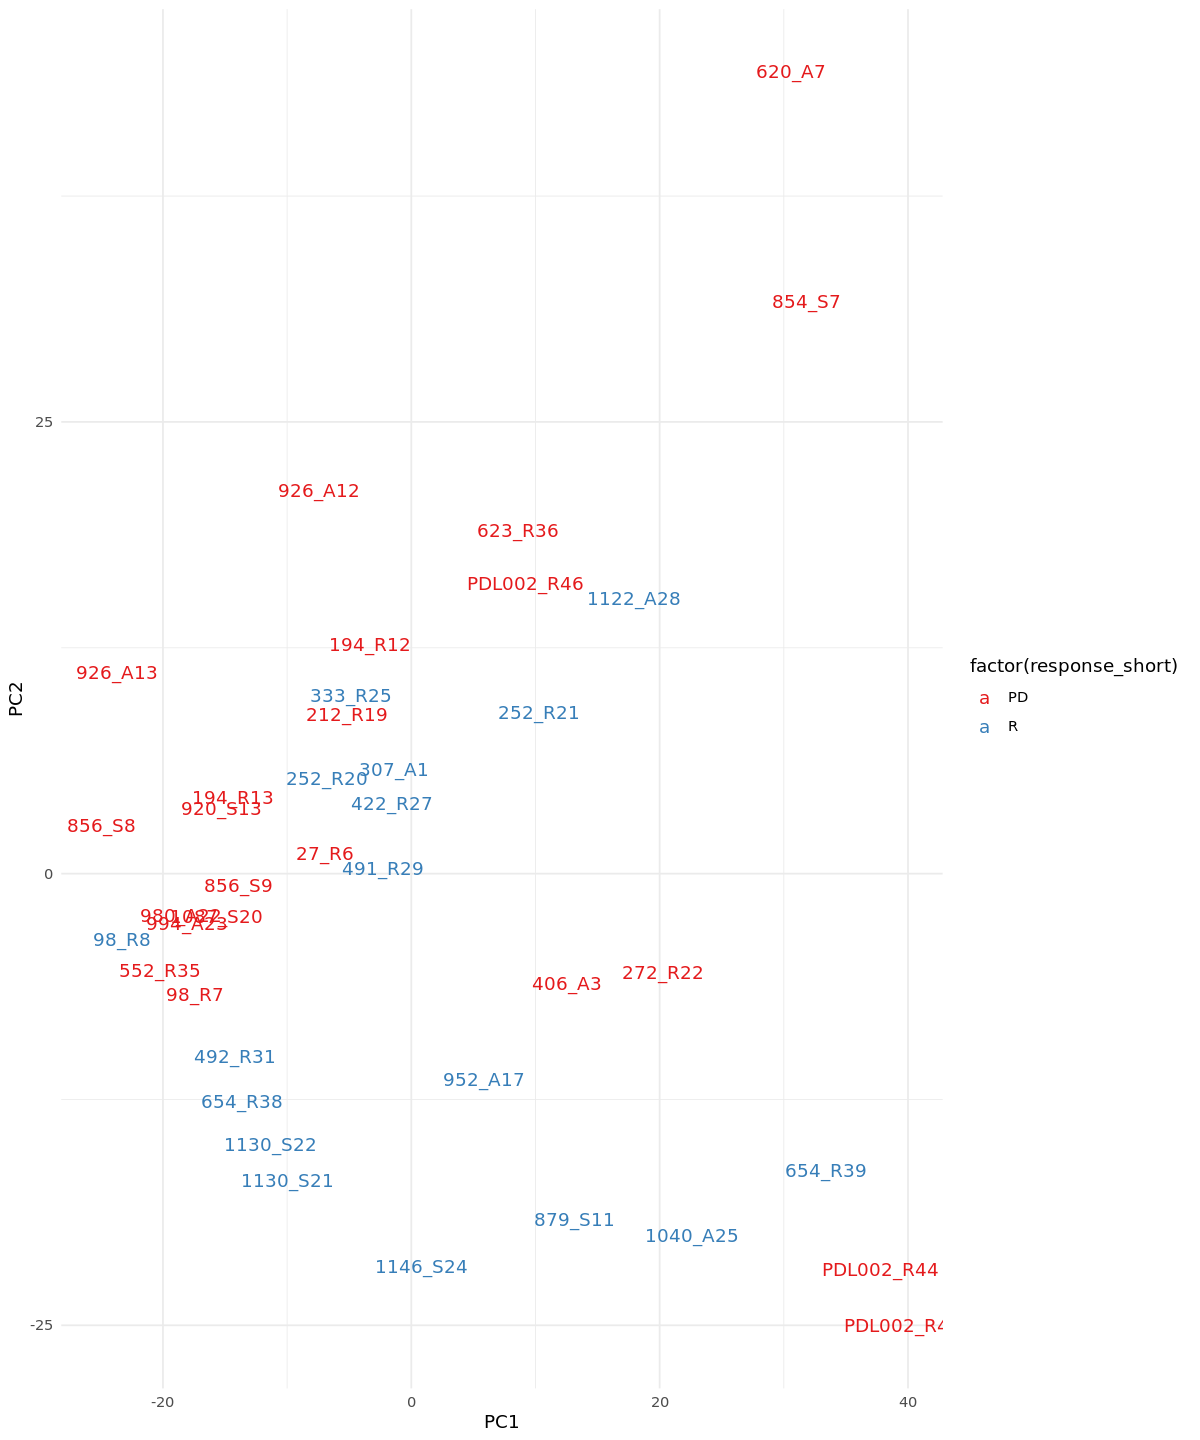

In [84]:
pcaData <- plotPCA(vsd, intgroup = c('response_short', 'sample'), returnData = TRUE) 

# pdf(file = './../../data-lab5/cohort_master/DEseq_result/PCAplot_allICI_072221.pdf', width = 6,height = 4)

ggplot(pcaData, aes(x = PC1, y = PC2, color = factor(response_short)))+ 
           scale_color_brewer(palette="Set1") + geom_text(aes(label=sample)) +
    theme_minimal() 

# dev.off()

In [85]:
# Extract the rlog matrix from the object and compute pairwise correlation values
vsd_mat <- assay(vsd)
vsd_cor <- cor(vsd_mat)


In [86]:
RECIST_annotation[RECIST_annotation == ''] <- 'WT'

In [87]:
anno_col = list(response_short = c(PD = "salmon", R = "lightgreen"), 
    treatment_group = c(ICI_PD1 = 'cyan', ICI_combo = 'steelblue1', ICI_CTLA4 = 'mediumblue', ICI_PDL1 = 'lightslateblue'),
     sex = c(M = 'lightblue2', F = 'mistyrose'), 
     state = c(PRE = 'lightyellow', ON ='gold1', POST ='sandybrown'),
     BRAF = c(Mut = 'thistle1', unknown = 'gray88',  WT = 'white'),
     NRAS= c(Mut = 'thistle1', unknown = 'gray88',  WT = 'white'),
     NF1= c(Mut = 'thistle1', unknown = 'gray88',  WT = 'white'),
     TERT= c(Mut = 'thistle1', unknown = 'gray88',  WT = 'white'),
     TP53.TP63= c(Mut = 'thistle1', unknown = 'gray88',  WT = 'white'),
     PTEN= c(Mut = 'thistle1', unknown = 'gray88',  WT = 'white'),
      MAP2K1.MAP3K2 = c(Mut = 'thistle1', unknown = 'gray88', WT = 'white')      
               )

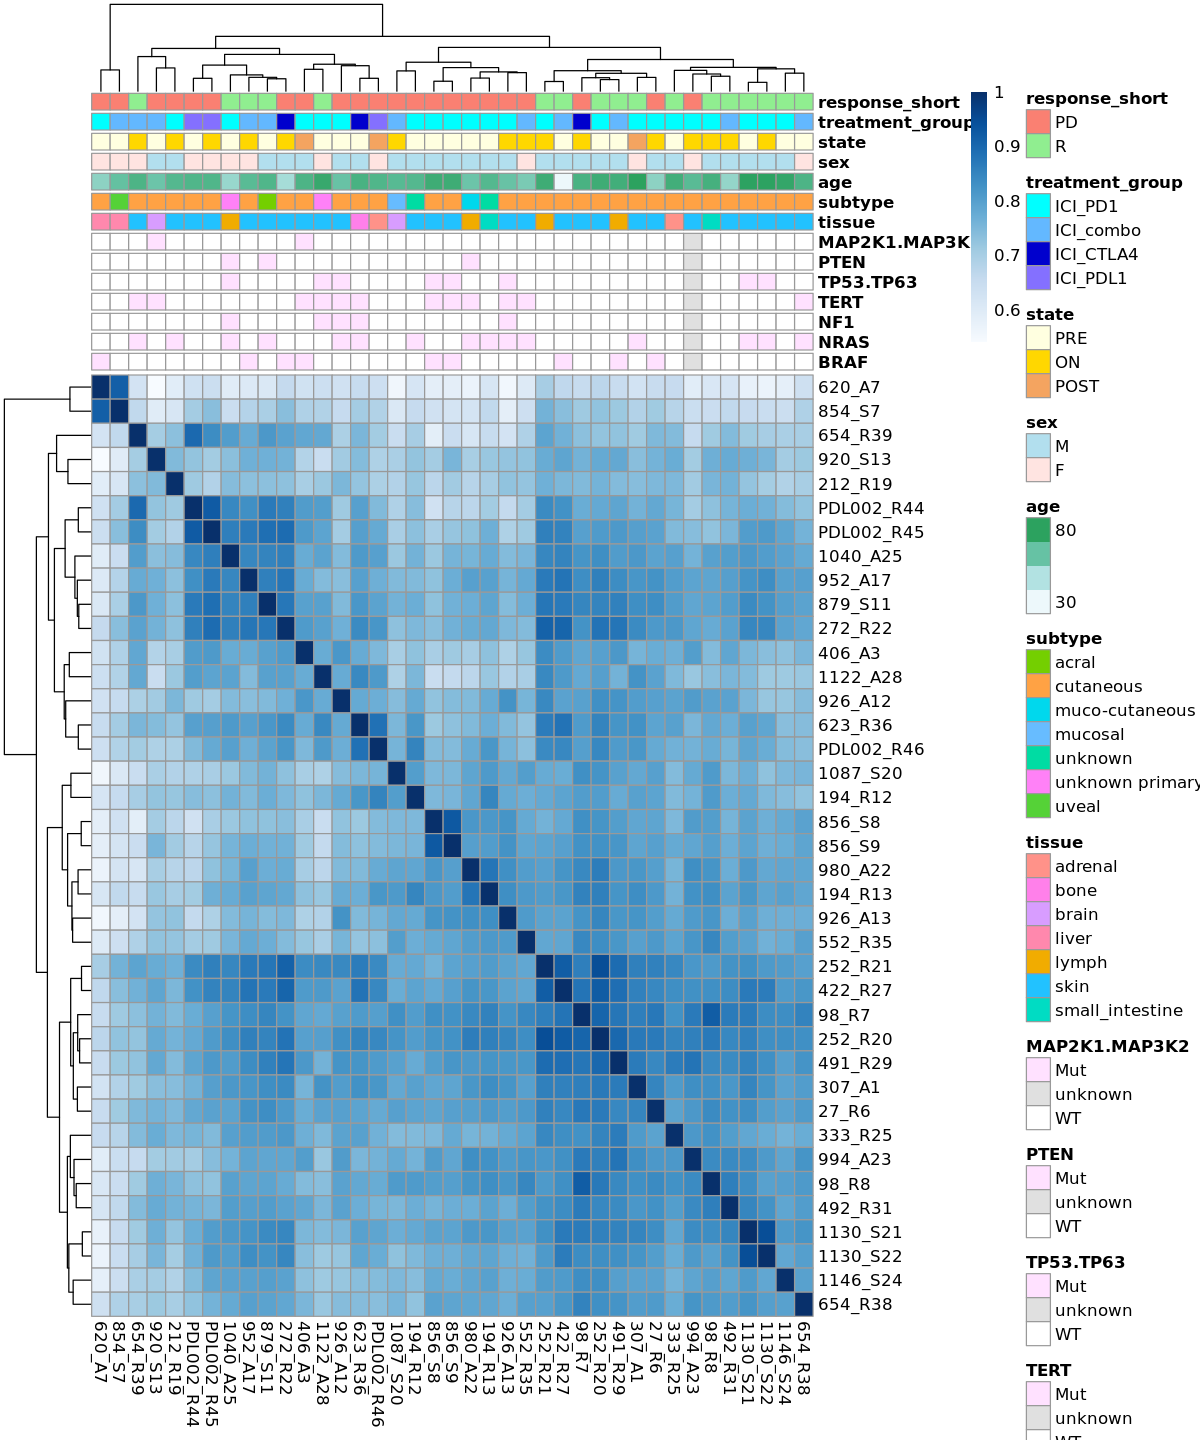

In [88]:
# Plot heatmap
options(repr.plot.width=10, repr.plot.height=12)

ph <-  pheatmap(vsd_cor, 
         annotation = RECIST_annotation[c("BRAF","NRAS","NF1","TERT","TP53.TP63","PTEN", "MAP2K1.MAP3K2", "tissue", 'subtype','age','sex', 'state', 'treatment_group', 'response_short')], 
         fontsize = 10, 
        height = 12,
        width = 9, 
         colorRampPalette( brewer.pal(9, "Blues")) (255),
#         filename = './../../data-lab5/cohort_master/DEseq_result/heatmapCorrelation_allICI_081321.pdf',
         annotation_colors =anno_col
        )

In [29]:
data.frame(sample = rep(c("tumour", "normal"), c(4,2)))

sample
<chr>
tumour
tumour
tumour
tumour
normal
normal


### Run DESeq2

In [33]:
# Run DESeq2
dds <- DESeq(dds)
resultsNames(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 897 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"              "response_short_R_vs_PD"

## Extract the results

In [34]:
deseq_result = results(dds, contrast=list("response_short_R_vs_PD"), alpha=0.05, tidy = TRUE)

In [35]:
head(deseq_result)

,row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TSPAN6,92.95883,-1.2991335,0.4327308,-3.0021746,0.002680584,0.1059343
2,DPM1,54.20897,-0.4717575,0.2301909,-2.0494192,0.040421144,0.3214160
3,SCYL3,59.19286,-0.2903784,0.2139859,-1.3569978,0.174781909,0.5597875
4,C1orf112,24.06713,-0.3065839,0.2681044,-1.1435245,0.252820871,0.6353964
5,FGR,24.84225,-0.1558922,0.5206124,-0.2994401,0.764604258,0.9241316
6,CFH,765.53679,-1.4727031,0.5648600,-2.6072001,0.009128598,0.1724975


In [36]:
# save the results for GSEA analysis
readr::write_csv(deseq_result, file='./../../data-lab5/cohort_master/DEseq_result/ICI_R_vs_PD_42samples_062421.csv')


# Visualize DE genes

In [37]:
### Set thresholds
padj.cutoff <- 0.05
lfc.cutoff <- 1.58
#The lfc.cutoff is set to 0.58; translates to an actual fold change of 1.5 
sig_genes <- deseq_result %>%
  data.frame() %>%
  dplyr::filter(padj < padj.cutoff & abs(log2FoldChange) > lfc.cutoff) %>%
  dplyr::arrange(desc(log2FoldChange))

In [38]:
sig_genes

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IGLV1-44,36.723353,3.350062,0.8731402,3.836797,1.246492e-04,0.023339447
IGKV2D-28,33.499764,3.294225,0.9200363,3.580538,3.428869e-04,0.039542922
HULC,24.337478,1.872623,0.4232622,4.424262,9.677262e-06,0.004896070
DDT,67.708176,-1.587915,0.3601401,-4.409160,1.037723e-05,0.005086141
EBP,61.545378,-1.598512,0.3922219,-4.075530,4.590970e-05,0.013585805
MT-ATP6,20001.882734,-1.614144,0.4214543,-3.829939,1.281751e-04,0.023375558
MTRNR2L12,21462.160110,-1.630191,0.4365693,-3.734096,1.883909e-04,0.027278937
IGFBP3,399.225366,-1.636115,0.4290445,-3.813393,1.370717e-04,0.023717947
MT-ND3,1734.091573,-1.641982,0.4075450,-4.028958,5.602474e-05,0.015415649


## volcano plot

In [39]:
vocano_df <- deseq_result %>% column_to_rownames('row')

#color DEG
vocano_df$diffexpressed <- "NO"
vocano_df$diffexpressed[vocano_df$log2FoldChange > lfc.cutoff & vocano_df$padj < padj.cutoff] <- "UP"
vocano_df$diffexpressed[vocano_df$log2FoldChange < -lfc.cutoff & vocano_df$padj < padj.cutoff] <- "DOWN"

vocano_df$delabel <- NA
vocano_df$delabel[vocano_df$diffexpressed != "NO"] <- rownames(vocano_df)[vocano_df$diffexpressed != "NO"]



Warning message:
“Removed 311 rows containing missing values (geom_point).”
Warning message:
“Removed 15888 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 90 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


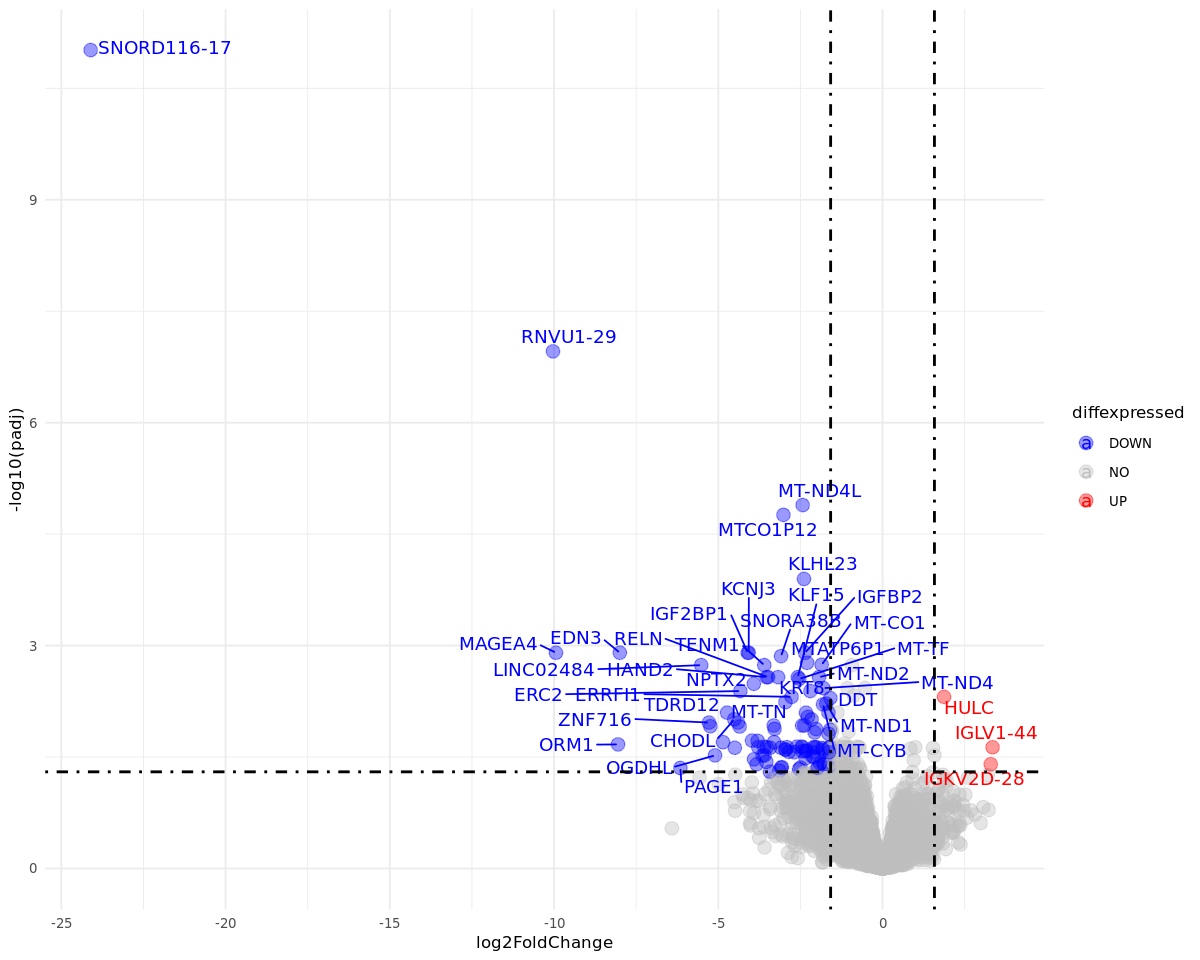

In [43]:
library(ggrepel)
options(repr.plot.width=10, repr.plot.height=8)

# plot adding up all layers we have seen so far
ggplot(data=vocano_df, aes(x=log2FoldChange, y=-log10(padj),col=diffexpressed, label=delabel)) +
        geom_point(alpha=0.4, size=3.5) +
        scale_color_manual(values=c("blue", "grey","red"))+       
        theme_minimal() + 
        theme(text = element_text(size = 10)) +
        geom_text_repel(max.overlaps = 30) +
        geom_vline(xintercept=c(-lfc.cutoff,lfc.cutoff),lty=4,col="black",lwd=0.8) +
        geom_hline(yintercept = -log10(padj.cutoff),lty=4,col="black",lwd=0.8) 

## MA plots

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



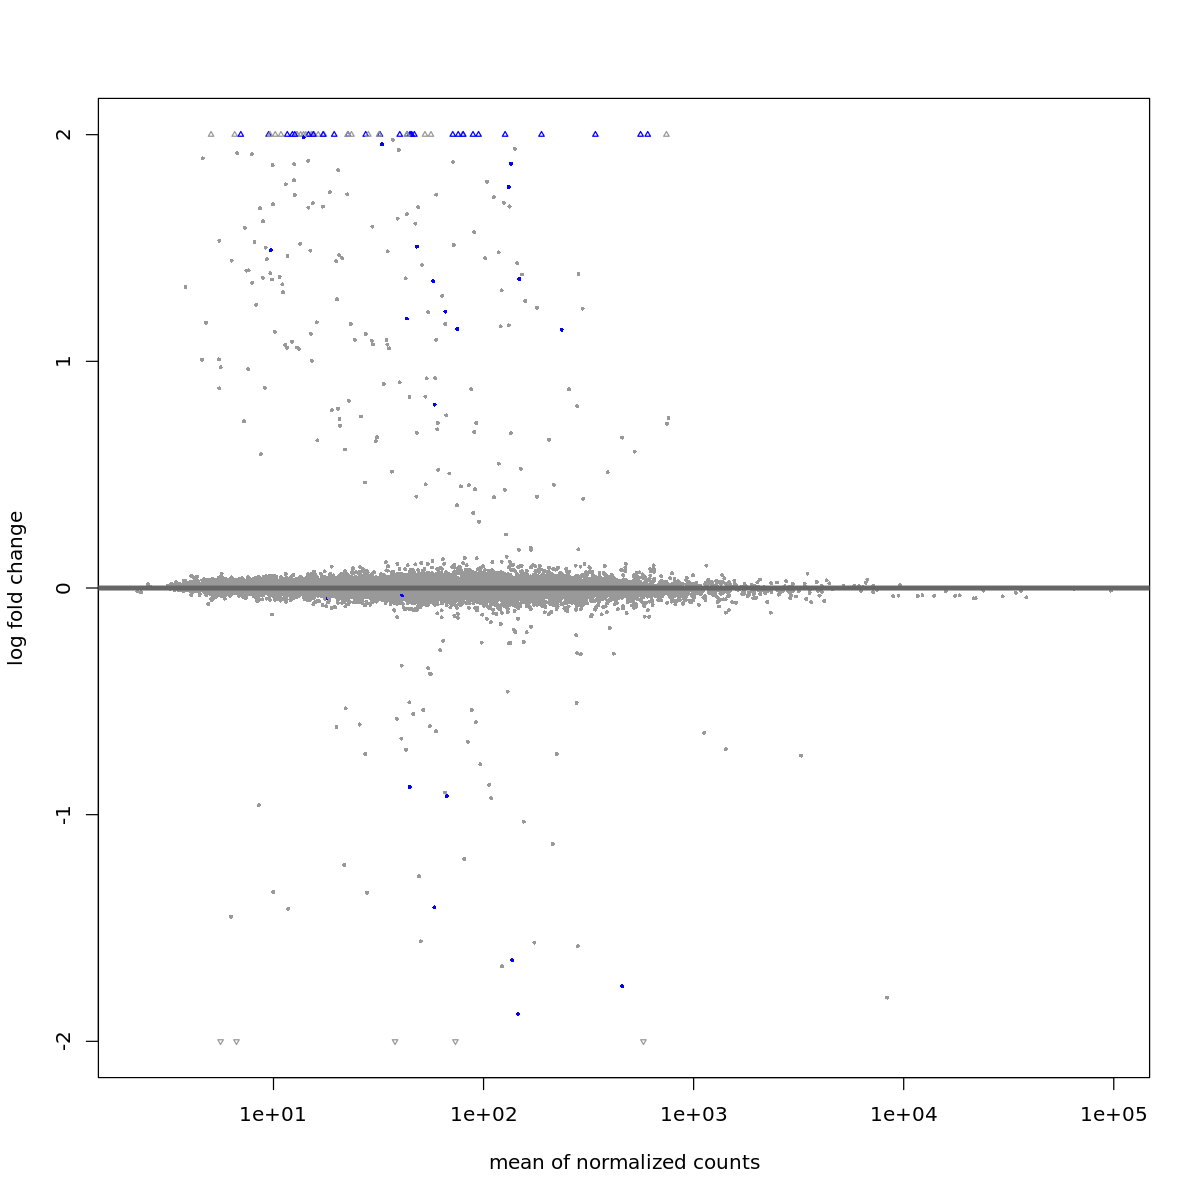

In [99]:
resLFC <- lfcShrink(dds, coef="condition_R_vs_PD", type="apeglm")
plotMA(resLFC, ylim=c(-2,2))


# Heatmap of differentially expressed genes

## Prepare the normalized counts

In [44]:
normalized_counts <- counts(dds, normalized=TRUE)

In [45]:
head(normalized_counts)

,307_A1,406_A3,406_A4,620_A7,854_S7,856_S8,856_S9,879_S11,920_S13,926_A12,⋯,491_R29,492_R31,552_R34,552_R35,623_R36,654_R38,654_R39,PDL002_R44,PDL002_R45,PDL002_R46
TSPAN6,33.98175,21.998232,5.737138,556.81665,504.61489,100.170785,69.149218,22.78584,6.575872,140.424176,⋯,40.86350,40.566258,0.000000,42.152905,109.57534,68.53140,7.456504,29.96524,43.76904,119.23956
DPM1,62.48257,55.642587,28.685690,65.50784,76.82718,99.342927,64.209988,51.26813,54.798935,42.737793,⋯,38.74072,31.314304,0.000000,14.267137,64.03754,48.60948,45.416885,21.89768,56.56306,62.83282
SCYL3,33.98175,85.404901,57.371380,120.93755,54.12824,52.155037,48.404453,53.16695,10.959787,80.591266,⋯,40.86350,62.628608,44.582720,92.736390,46.24933,82.87518,39.316109,59.93049,43.76904,51.40867
C1orf112,42.75123,7.764082,5.737138,40.31252,15.71465,12.417866,4.939230,19.93761,26.303489,23.200516,⋯,23.88127,17.792218,0.000000,45.395436,12.80751,15.93753,12.201551,17.28764,14.81414,22.13429
FGR,13.15423,46.584492,57.371380,10.07813,20.95287,1.655715,2.963538,43.67285,81.102424,7.326479,⋯,10.08320,8.540265,113.483288,5.836556,42.69169,0.00000,136.250655,80.67566,45.11578,18.56424
CFH,260.89215,335.149537,109.005622,9352.50404,6252.68487,62.917187,59.270758,273.43004,43.839148,377.313656,⋯,330.09219,618.457508,8.105949,18.806681,552.14588,81.28142,563.982812,885.12723,1548.75055,2596.13794


In [46]:
normalized_counts <- normalized_counts %>% 
  as.data.frame %>%
  rownames_to_column(var="row")

In [47]:
### Extract normalized expression for significant genes and rename gene 
norm_sig_genes <- normalized_counts %>% 
  dplyr::filter(row %in% sig_genes$row) %>% 
  column_to_rownames(var="row") 

In [48]:
col_order <- RECIST_annotation[c('response_short', 'treatment_group', 'state')] %>% 
    arrange( response_short, treatment_group,state) %>% rownames()

In [49]:
### Run pheatmap
run_pheatmap <- function(sig_genes, annotation)
    {
    pheatmap(sig_genes, 
             color = colorRampPalette(c("blue","white","red"))(256), 
             cluster_rows = T,
             cluster_cols = F,
             show_rownames = F,
             annotation = annotation, 
             border_color = NA, 
#              fontsize = 16, 
             scale = "row", 
             fontsize_row = 8, 
             height = 7,
             width = 7,
#              breaks = c(0,1000)
            )
    }

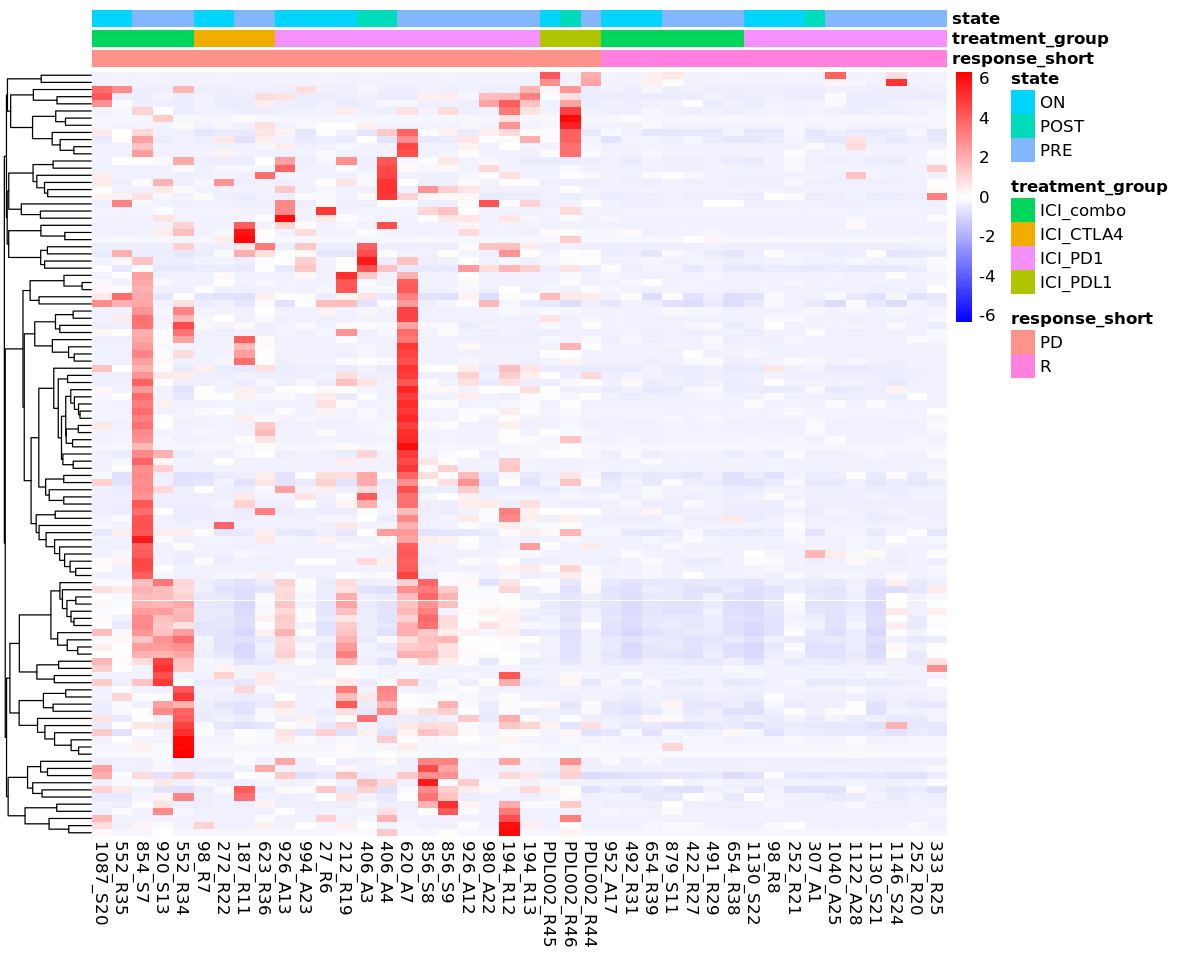

In [50]:
run_pheatmap(norm_sig_genes[col_order],RECIST_annotation[c('response_short', 'treatment_group', 'state')])

# Box plot

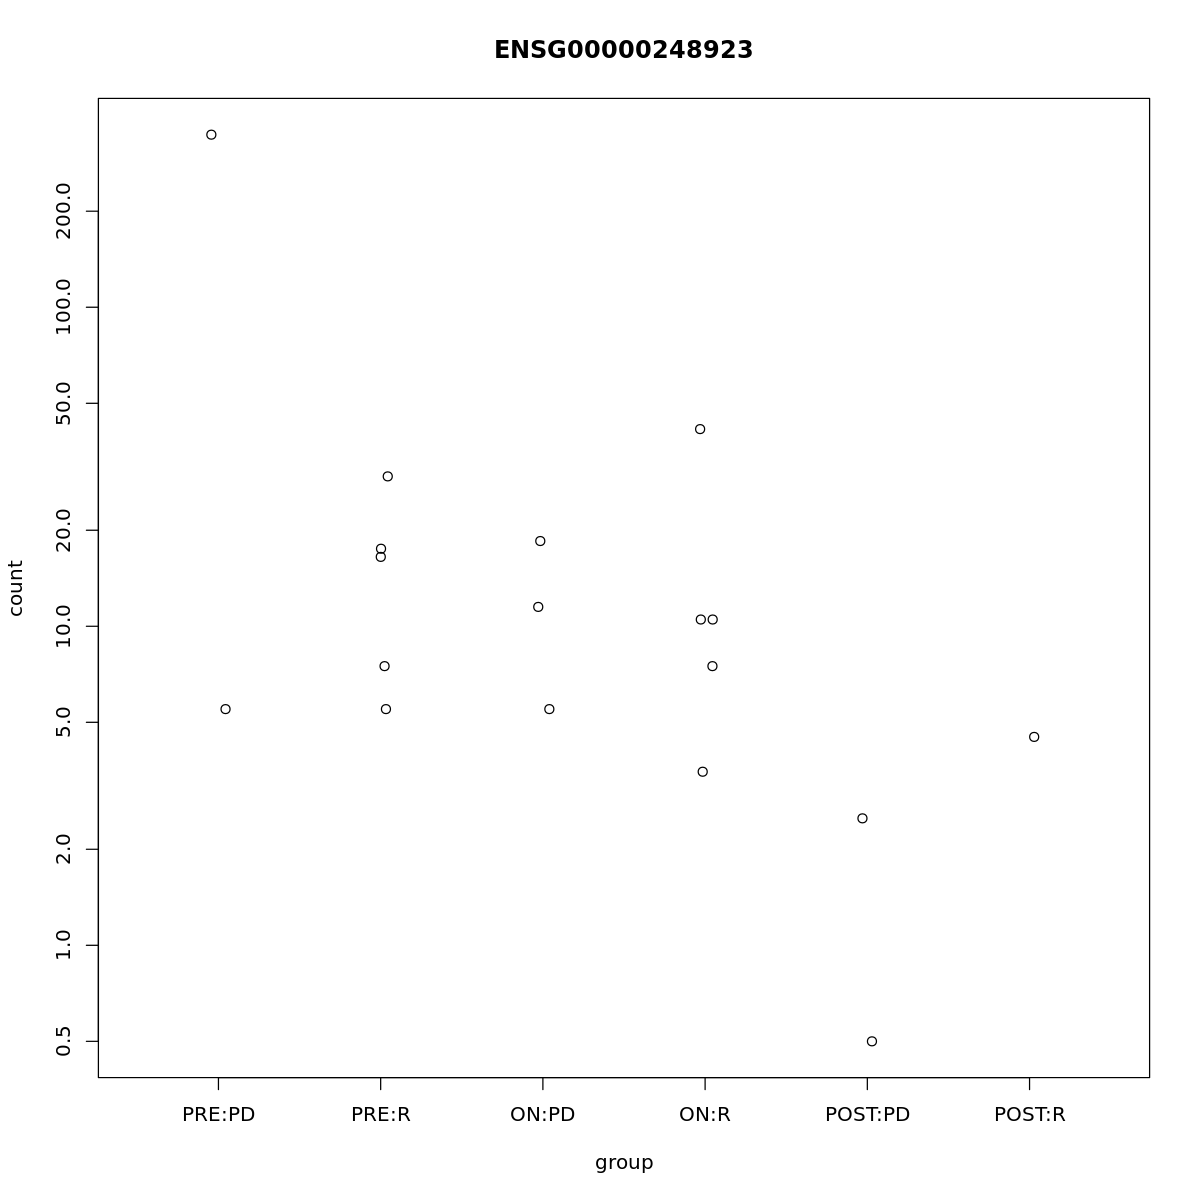

In [41]:
rawcount = plotCounts(dds, gene="ENSG00000248923", intgroup=c("state", "condition"), normalized = F)
